Setup

In [1]:
from LNL import define_save_LNL_model
from Full_model import define_model,train_and_save
import os
import time
from compare_imgs import show_img_compare, visualize_img_recep
from model_summary import show_lnr_combination
cwd = os.getcwd()
LNL_model_path = cwd+'/data/LNL_model.pth'

Define the LNL section of the model and saves it for later use

In [2]:
# whether to use curated resolvable gaussian radius of ERF
FHWM=False
# if not define current spread arbitrarily here
current_spread = 1
# define the electrode grid
elec_side_dim = 6
activ_spread= 0
#define neuron grid
neu_side_dim = 16

# define the LNL layer with gaussian electrical receptive field
W_d = define_save_LNL_model(LNL_model_path,elec_side_dim, neu_side_dim, activ_spread, current_spread,FHWM)

Define the Full model to be trained

In [3]:
# define the full model to be trained
drop_rate = 0.2
# options for activation functions are "linear", "2sig" and "ReLU"
activ_funcs = ["linear", "ReLU","ReLU"]
activ_func1 = activ_funcs[0]
activ_func2 = activ_funcs[1]
# shift and magnitude defines the 2sig function shape
shift = 2
magnitude = 2

AutoEncoder = define_model(elec_side_dim,neu_side_dim, LNL_model_path, drop_rate, activ_func1 ,activ_func2,shift,magnitude)

Train the model and save the model for result demo

In [4]:
# n_epochs = 50
# mult_lr = True
# start_time = time.time()
# train_and_save(n_epochs,AutoEncoder,mult_lr)
# end_time = time.time()
# execution_time = end_time - start_time
# print(f"Execution time: {execution_time} seconds")

Result Demo

In [5]:
# set the file directory to show
cwd = os.getcwd()
model_path = cwd+f'/data/240729_data/model_lr = 0.0001_lnr_6elec.pth'

Files already downloaded and verified
Files already downloaded and verified


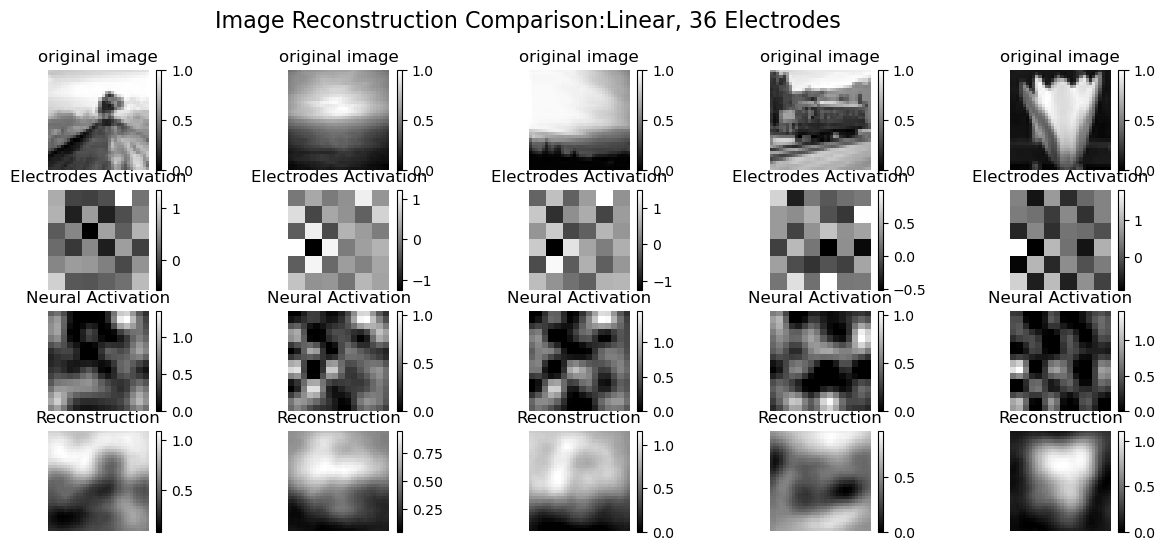

In [6]:
model_title = "Linear, 36 Electrodes"
show_img_compare(model_path, AutoEncoder,model_title)

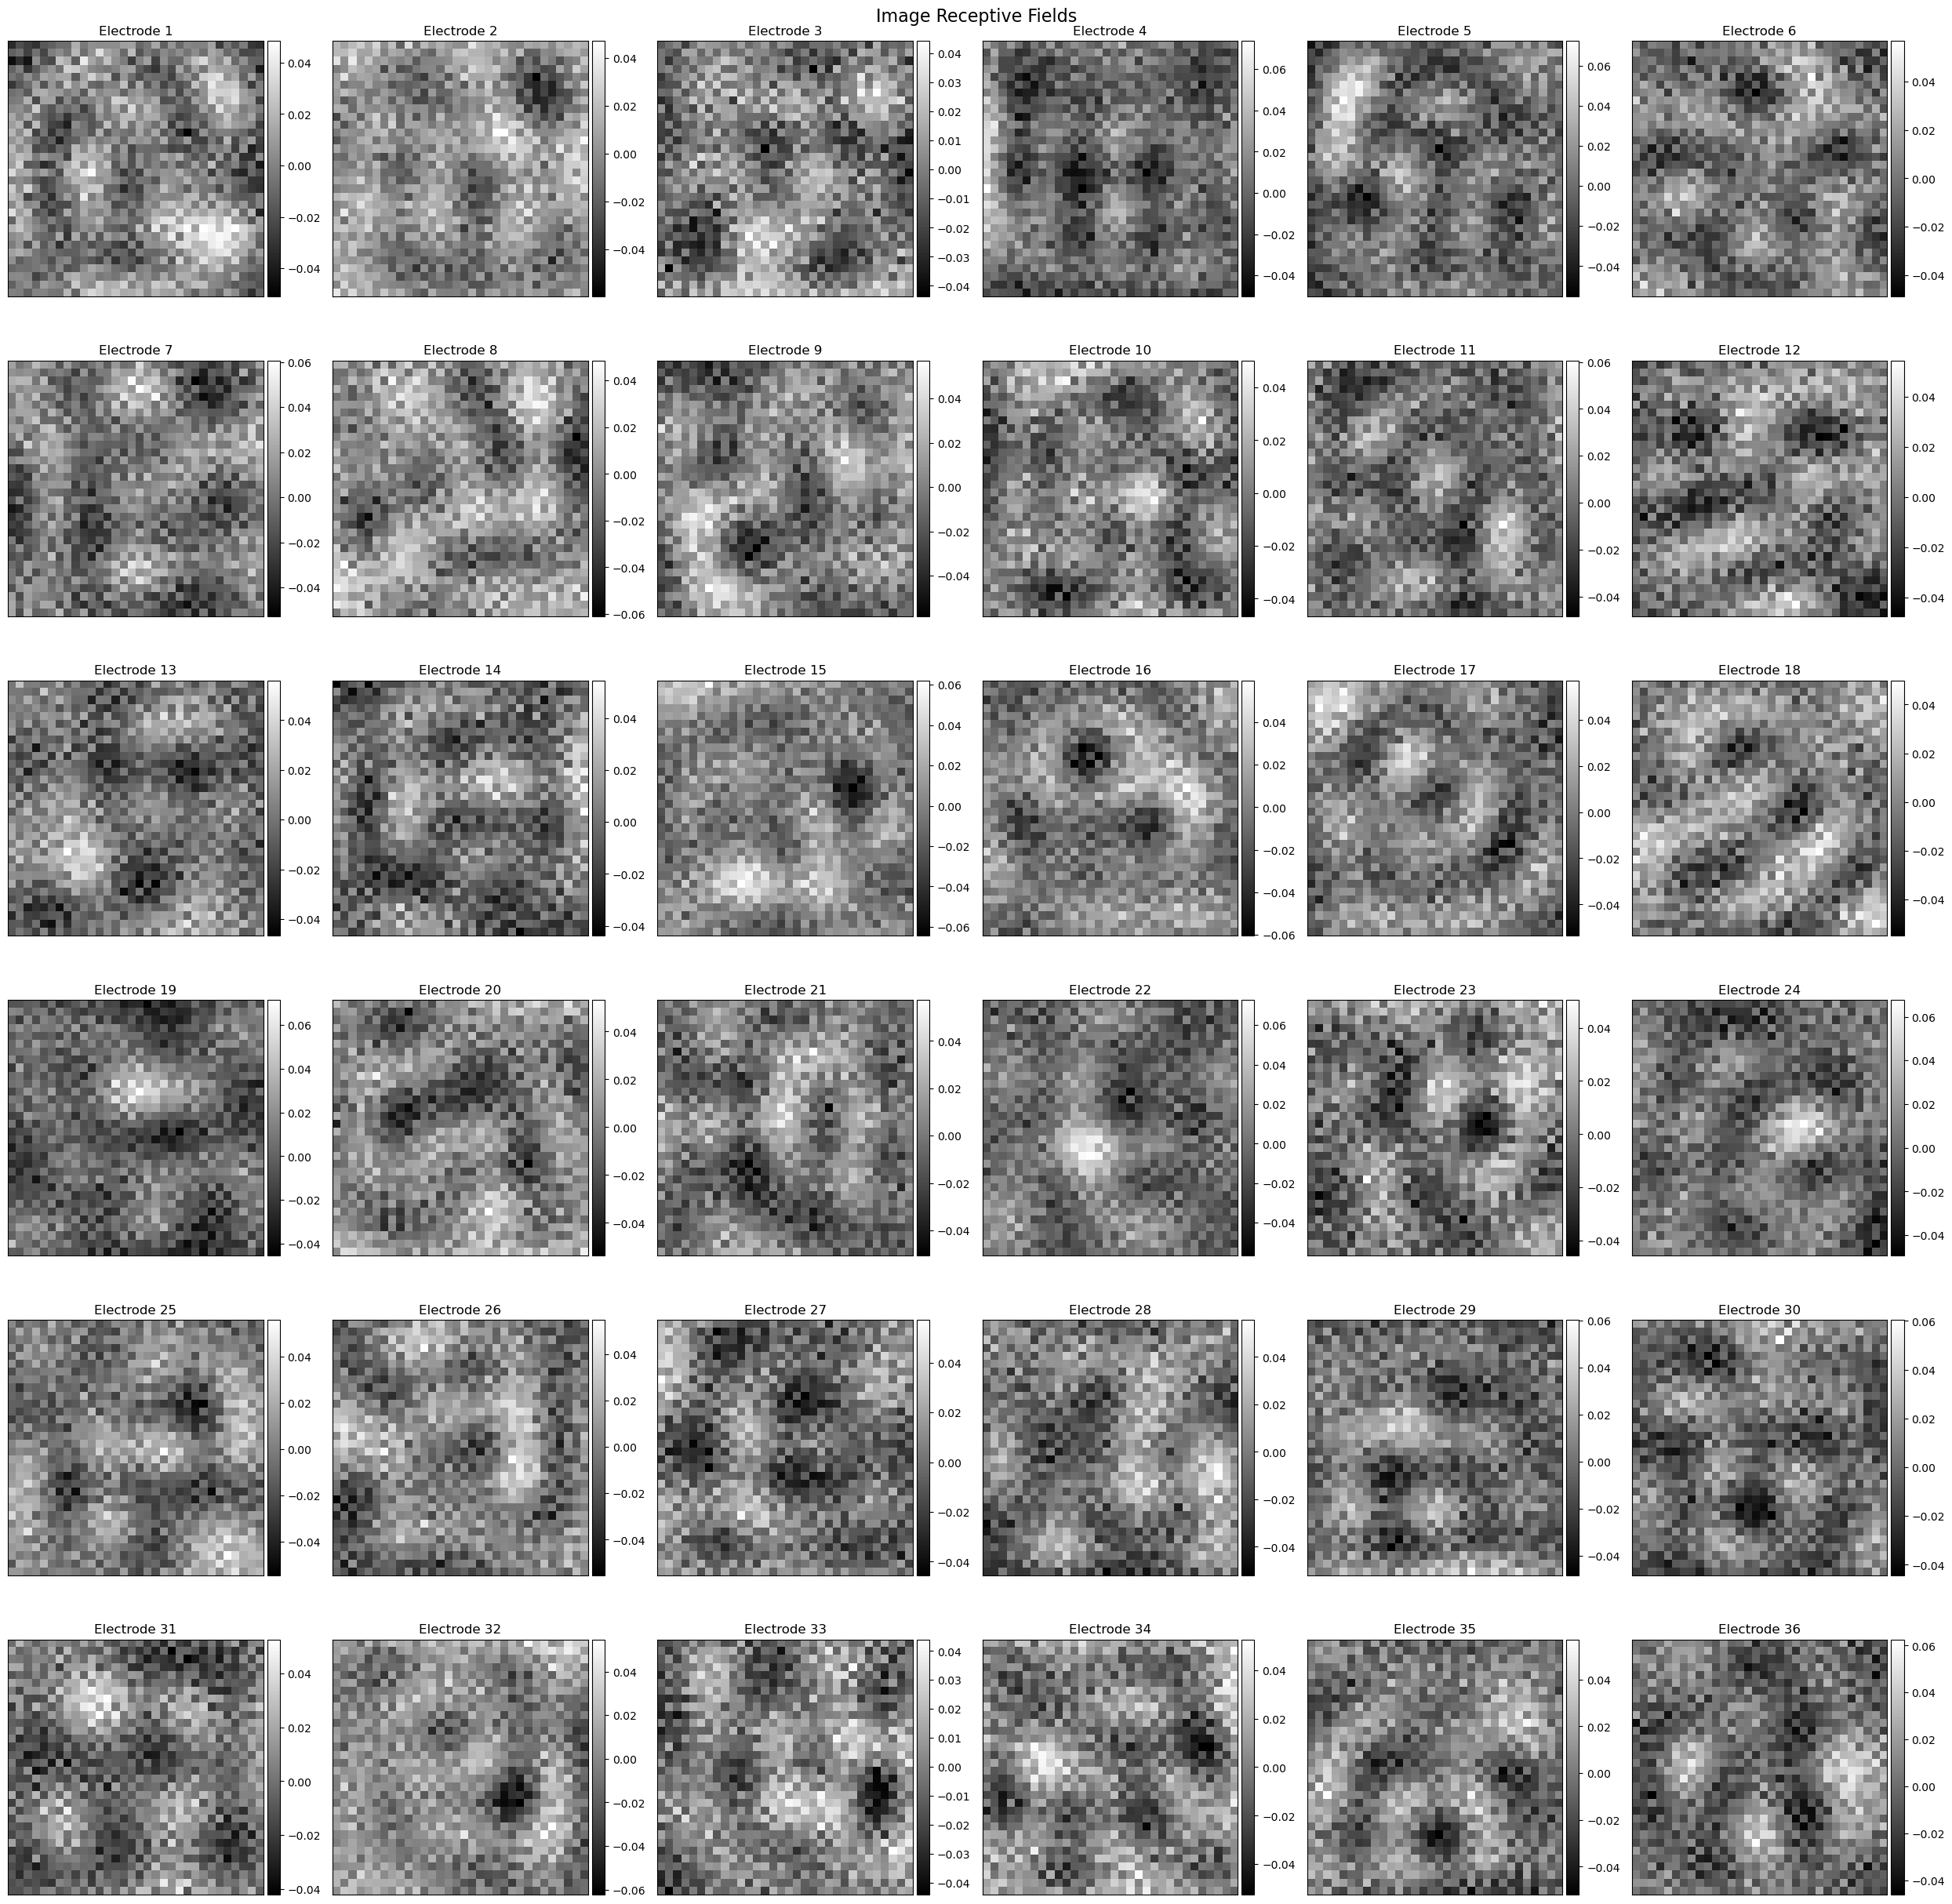

In [7]:
img_side_dim = 32
visualize_img_recep(model_path, AutoEncoder, img_side_dim,elec_side_dim)

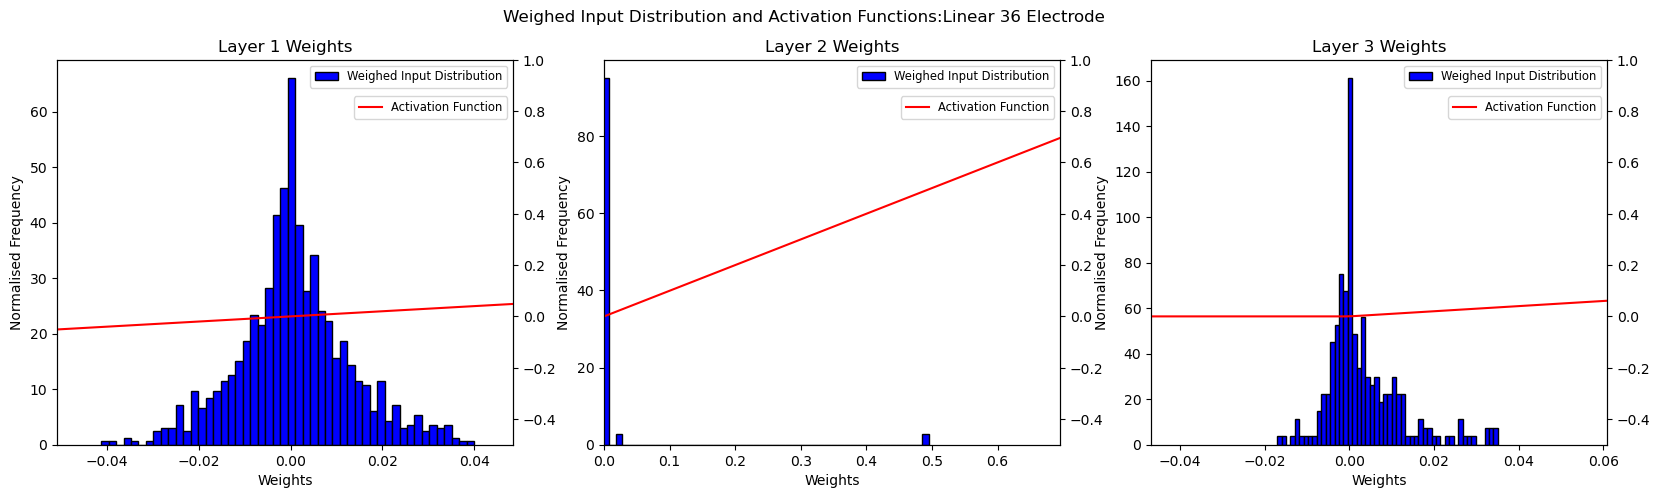

In [8]:
model_title = 'Linear 36 Electrodes'
show_lnr_combination(model_path,AutoEncoder, activ_funcs, magnitude, shift,model_title)